# Описание поставленной задачи

Целью данной работы является прогнозирование курса валюты доллара по данным за последний год. Исходные данные представляют из себя временной ряд с интервалом в один день, с августа 2024 по август 2025 год. Данные хранятся в файле course.csv.

Задача будет выполняться в несколько этапов:
1. Предобработка данных
2. Создание и проверка регрессионных, авторегрессионных моделей и моделей в пространстве состояний
3. Построение модели с применением Фурье-анализа

Перед началом работы импортируем необходимые библиотеки.

In [2]:
import pandas as pd
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.signal import cheby1, filtfilt, freqz
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import ttest_ind
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

## 1. Предобработка данных

### Подготовка датафрейма

Загрузим исходные данные и сохраним их в переменную course.

In [4]:
course = pd.read_csv('datasets/course.csv', sep = ';')
course.head()

,date,value
0,30.08.2025,"80,3316"
1,29.08.2025,"80,2918"
2,28.08.2025,"80,4421"
3,27.08.2025,"80,5268"
4,26.08.2025,"80,6842"


Данные загружены корректно. Изучим общую информацию о датафрейме.

In [6]:
course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    248 non-null    object
 1   value   248 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


Уже можем подметить несколько особенностей данных:

* У обоих столбцов тип данных строчный
  
* Временной ряд - неполный, из 365 записей присутствуют всего 248, пропуски появились скорее всего из-за нерабочих дней (праздников и выходных)

Установим верный тип данных для столбцов - тип даты и времени для date, тип вещественных чисел для value.

In [8]:
course['date'] = pd.to_datetime(course['date'], format = '%d.%m.%Y')

course['value'] = course['value'].str.replace(',', '.').astype(float)

print(course.info()) # выведем информацию о датафрейме

course.head() # выведем первые пять строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    248 non-null    datetime64[ns]
 1   value   248 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB
None


,date,value
0,2025-08-30,80.3316
1,2025-08-29,80.2918
2,2025-08-28,80.4421
3,2025-08-27,80.5268
4,2025-08-26,80.6842


Типы данных успешно изменены.

Проиндексируем датафрейм по столбцу date. При этом будем рассматривать все 365 дней, если для указанного дня нет значения value, то оно будет заполнено пропуском.

In [10]:
course = course.sort_values(by = 'date') # отсортируем по возрастанию даты

course = course.set_index('date').asfreq('D').reset_index() 

course.head() # выведем первые пять строк

,date,value
0,2024-08-31,91.1868
1,2024-09-01,NaN
2,2024-09-02,NaN
3,2024-09-03,90.0013
4,2024-09-04,88.6118


Индексация прошла успешно.

Теперь приведём временной ряд к полному. Для этого воспользуемся методом forward fill - пропуски будут заполняться предыдущим значением.

In [12]:
course['value'] = course['value'].ffill()

course.head()

,date,value
0,2024-08-31,91.1868
1,2024-09-01,91.1868
2,2024-09-02,91.1868
3,2024-09-03,90.0013
4,2024-09-04,88.6118


### Проверка на стационарность перед обработкой

Выполним проверку временного ряда на стационарность с помощью тестов Дики-Фуллера и KPSS теста.

**Тест Дики-Фуллера (ADF)**

In [14]:
result = adfuller(course['value'])
print('ADF stat:', result[0], 'p-value:', result[1])  # p < 0.05: стационарен
if result[1] < 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

ADF stat: -0.6701198210279872 p-value: 0.8543381292702841
Временной ряд нестационарен


**KPSS тест**

In [16]:
result = kpss(course['value'])
print('KPSS stat:', result[0], 'p-value:', result[1])  # p > 0.05: стационарен
if result[1] > 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

KPSS stat: 2.4012958248932916 p-value: 0.01
Временной ряд нестационарен


C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16388\1941409742.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(course['value'])


Оба теста определили ряд как нестанцинарный. Попробуем привести его к стационарному, продиффернцировав, то есть вычтя из текущего значения предыдущее. После дифференцирования, вновь выполним оба теста на стационарность

In [18]:
course['value_diff'] = course['value'].diff() # продифференцировали ряд
course = course.dropna()
result = adfuller(course['value_diff'])
print('ADF stat:', result[0], 'p-value:', result[1])  # p < 0.05: стационарен
if result[1] < 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = kpss(course['value_diff'])
print('KPSS stat:', result[0], 'p-value:', result[1])  # p > 0.05: стационарен
if result[1] > 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

ADF stat: -15.327885598642895 p-value: 3.9824223698314274e-28
Временной ряд стационарен
KPSS stat: 0.23839317652637818 p-value: 0.1
Временной ряд стационарен


C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16388\2514811528.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(course['value_diff'])


Оба теста определили дифференцированный ряд как станционарный. 

### Обработка аномалий с помощью Isolation Forest

Обработаем аномалии с помощью Isolation Forest: данная модель определит наиболее резкие изменения в данных.

Ввиду того, что Isolation Forest неидеально работает с временными рядами, мы добавим столбец с предыдущим значением (value_diff_lag_1), благодаря чему модель будет опираться на предыдущее значение.

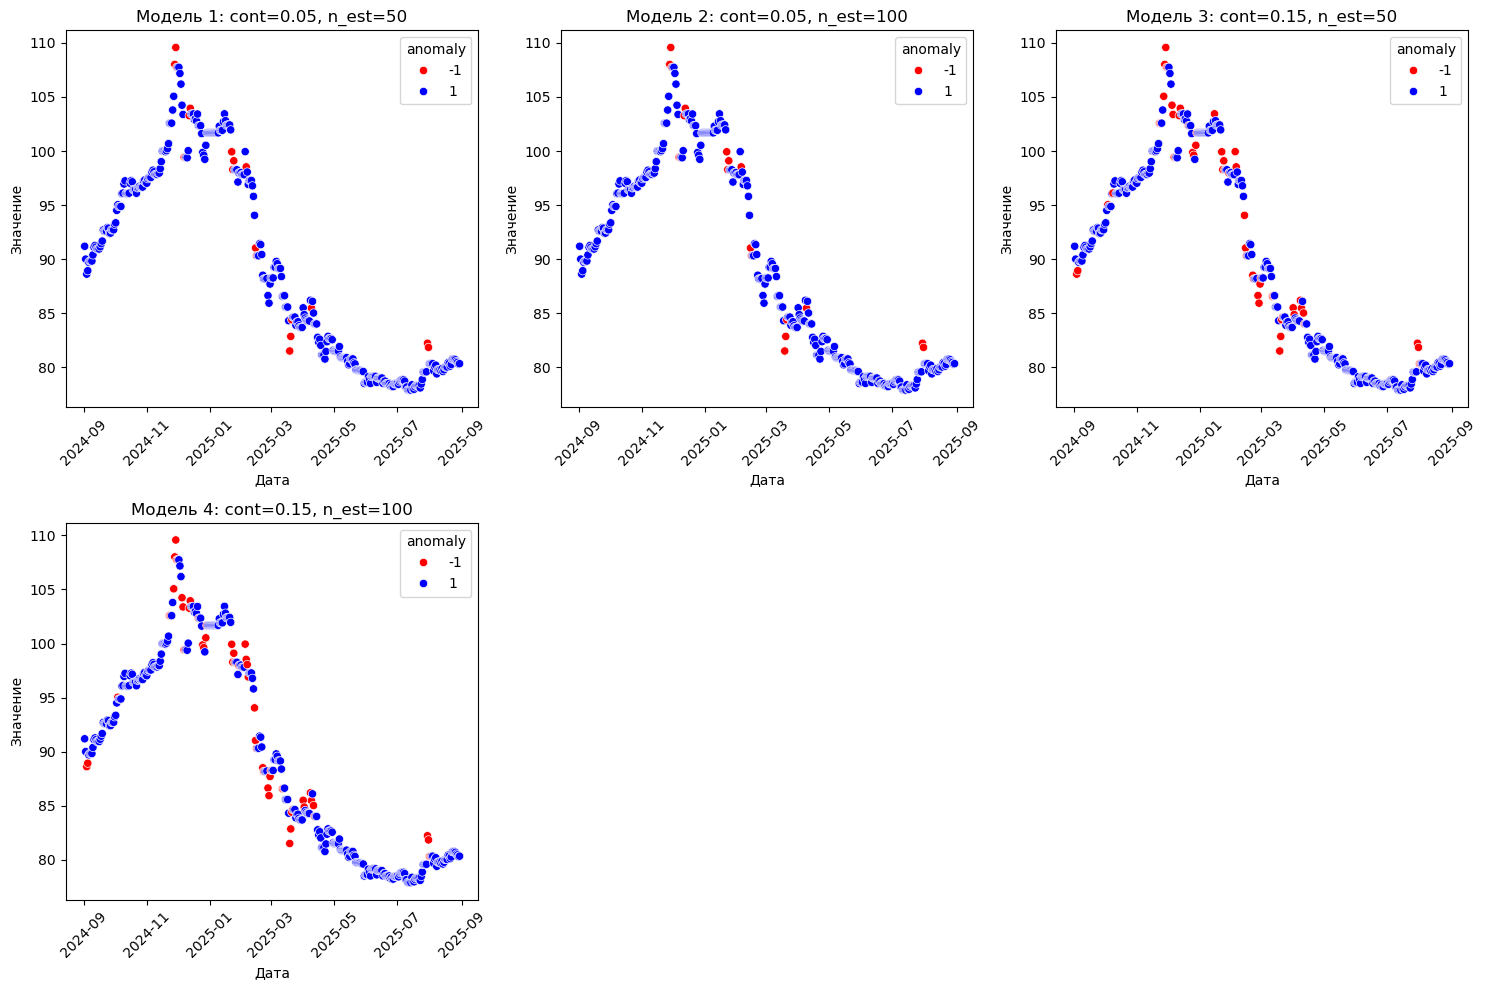

<Figure size 640x480 with 0 Axes>

In [20]:
# Шаг 0: Добавление значение лагов разницы

course['value_diff_lag_1'] = course['value_diff'].shift(1)
course = course.dropna()

# Шаг 1: Настройка параметров для Isolation Forest
param_grid = list(product(
    [0.05, 0.15],       # contamination
    [50, 100]              # n_estimators
))

# Шаг 2: Пайплайн и визуализация
n_models = len(param_grid)
plt.figure(figsize=(15, 5 * (n_models // 3 + 1)))
best_model = None
best_ratio_diff = float('inf')
expected_anomaly_ratio = 0.1

for i, params in enumerate(param_grid, 1):
    # Обучение Isolation Forest
    model = IsolationForest(
        contamination=params[0],
        n_estimators=params[1],
        random_state=42
    )
    course['anomaly'] = model.fit_predict(course[['value_diff', 'value_diff_lag_1']])
    
    # Метрика: доля аномалий
    anomaly_ratio = (course['anomaly'] == -1).mean()
    # print(f"Модель {i}: cont={params[0]}, n_est={params[1]}, max_s={params[2]}, max_f={params[3]}, boot={params[4]}, доля аномалий={anomaly_ratio:.3f}")
    
    # Сохраняем лучшую модель
    ratio_diff = abs(anomaly_ratio - expected_anomaly_ratio)
    if ratio_diff < best_ratio_diff:
        best_ratio_diff = ratio_diff
        best_model = params
    
    # Визуализация
    plt.subplot((n_models // 3 + 1), 3, i)
    sns.scatterplot(x=course['date'], y=course['value'], hue=course['anomaly'], palette={1: 'blue', -1: 'red'})
    plt.title(f"Модель {i}: cont={params[0]}, n_est={params[1]}")
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

Наиболее оптимально резкие скачки определила модель 1 изоляционного леса со следующими параметрами:

* contamination = 0.05 - ожидаемая доля аномалий в данных (0.05 = 5%). Определяет порог для классификации точек как аномалий; выше — больше аномалий выявляется.
* n_estimators = 50 - количество деревьев в лесу. Больше деревьев — стабильнее модель, но дольше обучение.
  
Значения которые оказались аномальными проинтерполируем между ближайшими неаномальными значениями.

(array([19967., 20028., 20089., 20148., 20209., 20270., 20332.]),
 [Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03'),
  Text(20209.0, 0, '2025-05'),
  Text(20270.0, 0, '2025-07'),
  Text(20332.0, 0, '2025-09')])

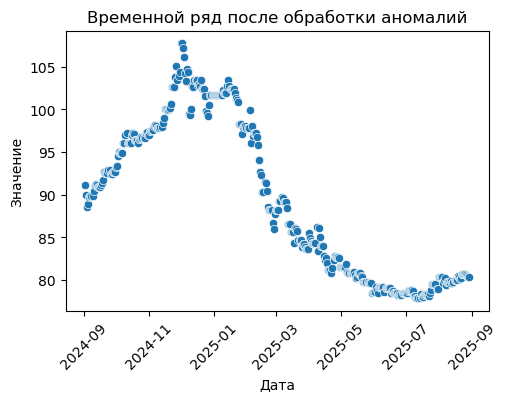

In [22]:
# Обнаружение аномалий
model = IsolationForest(contamination=0.05, n_estimators=50, random_state=42)
course['anomaly'] = model.fit_predict(course[['value_diff', 'value_diff_lag_1']])

# Интерполяция аномалий
course['value'] = course['value'].where(course['anomaly'] == 1)  # Аномалии = NaN
course['value'] = course['value'].interpolate(method='spline', order = 3)  # Сплайновая интерполяция

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x=course['date'], y=course['value'])
plt.title('Временной ряд после обработки аномалий')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.xticks(rotation=45)

Аномалии успешно обработаны.

### Тест на белый шум через статистику Бокса-Пирса

Проверим продифференцированный временной ряд на белый шум. 

In [24]:
# Тест на разности
bp_test_diff = acorr_ljungbox(course['value_diff'], lags=25, boxpierce=True)
bp_stat_diff = bp_test_diff['lb_stat']
bp_pvalue_diff = bp_test_diff['bp_pvalue']
print("\nБокса-Пирса (разности очищенного ряда):")
for lag, stat, pval in zip(range(1, 26), bp_stat_diff, bp_pvalue_diff):
    print(f"Лаг {lag}: статистика={stat:.3f}, p-value={pval:.3f}")


Бокса-Пирса (разности очищенного ряда):
Лаг 1: статистика=16.373, p-value=0.000
Лаг 2: статистика=16.379, p-value=0.000
Лаг 3: статистика=16.484, p-value=0.001
Лаг 4: статистика=16.582, p-value=0.002
Лаг 5: статистика=16.938, p-value=0.005
Лаг 6: статистика=17.177, p-value=0.009
Лаг 7: статистика=17.286, p-value=0.017
Лаг 8: статистика=21.671, p-value=0.006
Лаг 9: статистика=25.824, p-value=0.003
Лаг 10: статистика=26.052, p-value=0.004
Лаг 11: статистика=27.153, p-value=0.005
Лаг 12: статистика=27.946, p-value=0.007
Лаг 13: статистика=28.235, p-value=0.010
Лаг 14: статистика=28.549, p-value=0.014
Лаг 15: статистика=28.960, p-value=0.019
Лаг 16: статистика=31.423, p-value=0.014
Лаг 17: статистика=32.549, p-value=0.016
Лаг 18: статистика=32.733, p-value=0.022
Лаг 19: статистика=33.551, p-value=0.025
Лаг 20: статистика=34.992, p-value=0.025
Лаг 21: статистика=35.070, p-value=0.034
Лаг 22: статистика=35.168, p-value=0.046
Лаг 23: статистика=35.181, p-value=0.061
Лаг 24: статистика=35.189

##### Присутствует большое количество шумов - значений, где p-value > 0.05, то есть автокорреляция на этих значениях отсутствует.

### Очистка данных от шума

Используя фильтр Чебышего 1-го рода, попробуем отчистить продифференцированный ряд от шума.

Фильтр Чебышева 1-го рода сгладит высокочастотные компоненты (собственно, шум), сохранив низкочастотные (тренд и сезонность). Будем использовать фильтр со следующими параметрами:

* Порядок фильтра (N = 3): Обычно 2–5 (низкий порядок для мягкого сглаживания)
* Критическая частота (Wn = 0.5): Доля частоты Найквиста (0–0.5). Меньше Wn — сильнее сглаживание
* Пульсация (rp = 1): Допустимое искажение в полосе пропускания (обычно 0.5–3 дБ)

In [26]:
# Фильтр Чебышева 1-го рода
b, a = cheby1(N = 3, rp = 1, Wn = 0.5, btype='low')
course['value_diff_filtered'] = np.nan
course.loc[course['value_diff'].notna(), 'value_diff_filtered'] = filtfilt(b, a, course['value_diff'].dropna())

# Тест Бокса-Пирса на отфильтрованных разностях
bp_test_filtered = acorr_ljungbox(course['value_diff_filtered'].dropna(), lags=25, boxpierce=True)
print("Бокса-Пирса (отфильтрованные разности):")
for lag, stat, pval in zip(range(1, 26), bp_test_filtered['lb_stat'], bp_test_filtered['bp_pvalue']):
    print(f"Лаг {lag}: статистика={stat:.3f}, p-value={pval:.3f}")

Бокса-Пирса (отфильтрованные разности):
Лаг 1: статистика=163.788, p-value=0.000
Лаг 2: статистика=168.303, p-value=0.000
Лаг 3: статистика=169.739, p-value=0.000
Лаг 4: статистика=172.819, p-value=0.000
Лаг 5: статистика=179.879, p-value=0.000
Лаг 6: статистика=179.903, p-value=0.000
Лаг 7: статистика=185.096, p-value=0.000
Лаг 8: статистика=189.840, p-value=0.000
Лаг 9: статистика=193.332, p-value=0.000
Лаг 10: статистика=197.478, p-value=0.000
Лаг 11: статистика=200.736, p-value=0.000
Лаг 12: статистика=202.172, p-value=0.000
Лаг 13: статистика=202.567, p-value=0.000
Лаг 14: статистика=202.651, p-value=0.000
Лаг 15: статистика=205.134, p-value=0.000
Лаг 16: статистика=210.001, p-value=0.000
Лаг 17: статистика=213.073, p-value=0.000
Лаг 18: статистика=214.552, p-value=0.000
Лаг 19: статистика=216.526, p-value=0.000
Лаг 20: статистика=219.452, p-value=0.000
Лаг 21: статистика=220.892, p-value=0.000
Лаг 22: статистика=220.908, p-value=0.000
Лаг 23: статистика=221.010, p-value=0.000
Лаг

Построим график разностей до и после фильтрации.

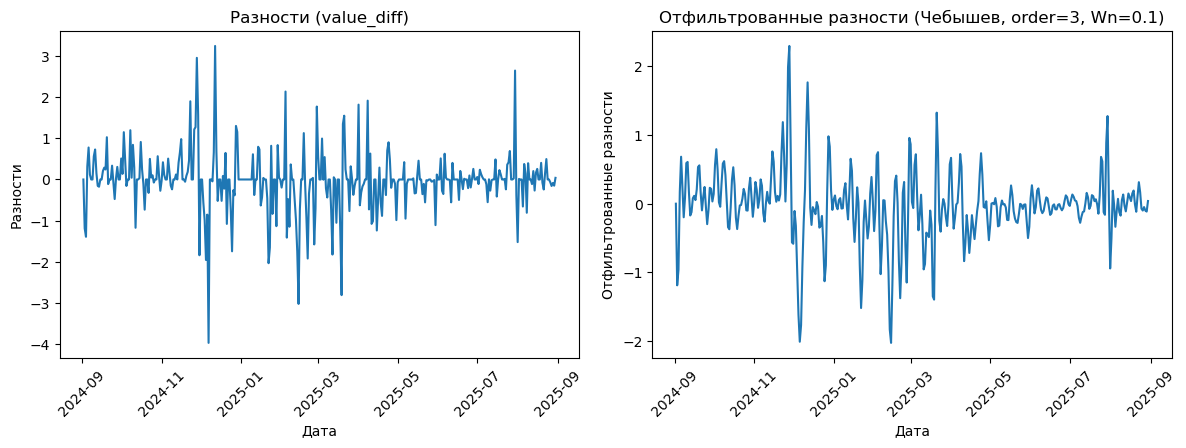

In [28]:
# Визуализация
plt.figure(figsize=(12, 8))
plt.clf()  # Очистка фигуры перед построением

# График разностей
plt.subplot(2, 2, 1)
sns.lineplot(x=course['date'], y=course['value_diff'])
plt.title('Разности (value_diff)')
plt.xlabel('Дата')
plt.ylabel('Разности')
plt.xticks(rotation=45)

# График отфильтрованных разностей
plt.subplot(2, 2, 2)
sns.lineplot(x=course['date'], y=course['value_diff_filtered'])
plt.title('Отфильтрованные разности (Чебышев, order=3, Wn=0.1)')
plt.xlabel('Дата')
plt.ylabel('Отфильтрованные разности')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Теперь восстановим отфильтрованные значения ряда через кумулятивную сумму.

(array([19967., 20028., 20089., 20148., 20209., 20270., 20332.]),
 [Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03'),
  Text(20209.0, 0, '2025-05'),
  Text(20270.0, 0, '2025-07'),
  Text(20332.0, 0, '2025-09')])

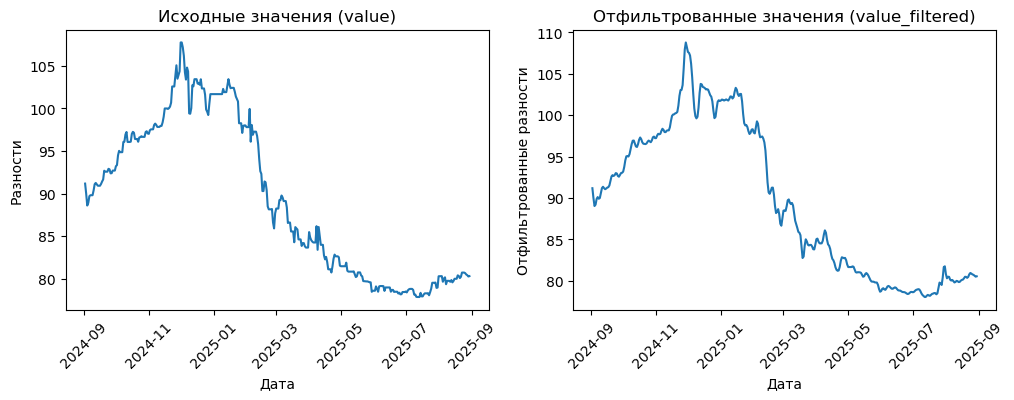

In [30]:
course['value_filtered'] = course['value_diff_filtered'].cumsum() + course['value'].iloc[0]

# Визуализация
plt.figure(figsize=(12, 8))
plt.clf()  # Очистка фигуры перед построением

# График значений
plt.subplot(2, 2, 1)
sns.lineplot(x=course['date'], y=course['value'])
plt.title('Исходные значения (value)')
plt.xlabel('Дата')
plt.ylabel('Разности')
plt.xticks(rotation=45)

# График отфильтрованных разностей
plt.subplot(2, 2, 2)
sns.lineplot(x=course['date'], y=course['value_filtered'])
plt.title('Отфильтрованные значения (value_filtered)')
plt.xlabel('Дата')
plt.ylabel('Отфильтрованные разности')
plt.xticks(rotation=45)

Данные успешно отчищены от шума. Построим амлитудно-частотную характеристику нашего фильтра.

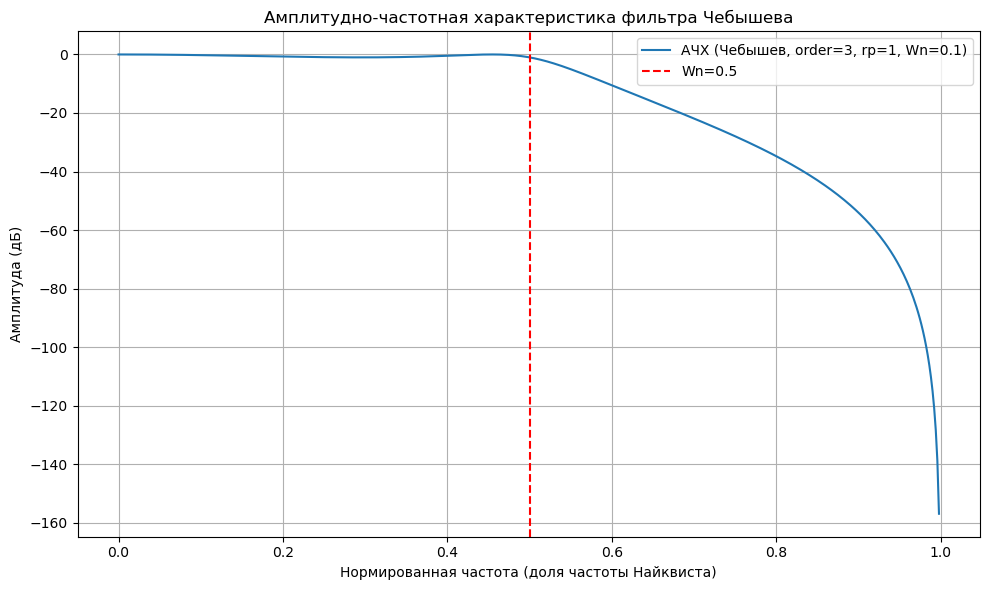

In [32]:
# Параметры фильтра Чебышева
order = 3  # Порядок фильтра
rp = 1     # Пульсация (дБ)
Wn = 0.5   # Критическая частота (нормирована к частоте Найквиста)

# Коэффициенты фильтра
b, a = cheby1(order, rp, Wn, btype='low', analog=False)

# Вычисление АЧХ
w, h = freqz(b, a, worN=512)  # worN — число точек для частот
freq = w / np.pi  # Нормированные частоты (0–1, где 1 — частота Найквиста)
amp_db = 20 * np.log10(np.abs(h))  # Амплитуда в дБ

# Визуализация АЧХ
plt.figure(figsize=(10, 6))
plt.clf()
plt.plot(freq, amp_db, label='АЧХ (Чебышев, order=3, rp=1, Wn=0.1)')
plt.axvline(x=Wn, color='r', linestyle='--', label=f'Wn={Wn}')
plt.title('Амплитудно-частотная характеристика фильтра Чебышева')
plt.xlabel('Нормированная частота (доля частоты Найквиста)')
plt.ylabel('Амплитуда (дБ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Сглаживание значений

Сгладим значения ряда с помощью взвешенного скользящего среднего по 3 точкам. Тут также будем сглаживать продиффиренцированные значения.

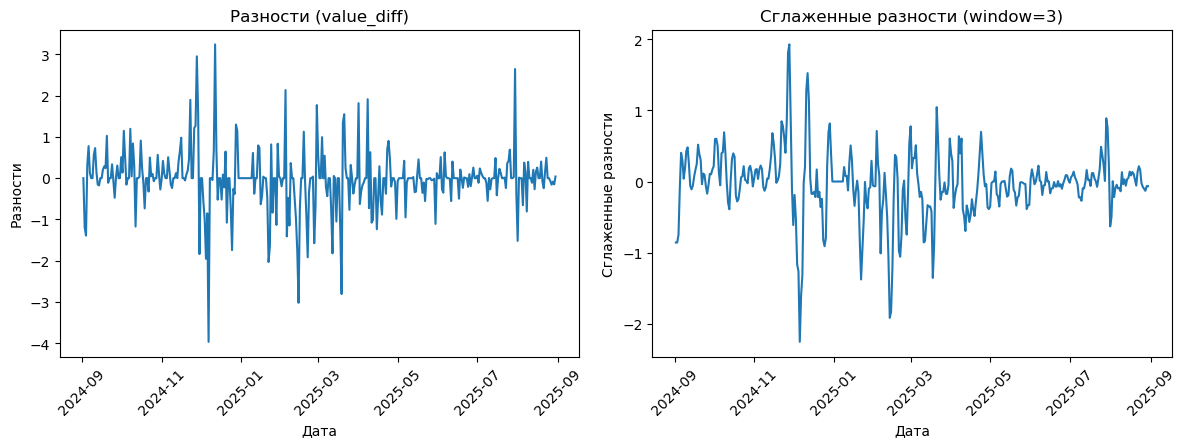

In [34]:
# Скользящее среднее по трём точкам
course['value_diff_smoothed'] = course['value_diff'].rolling(window=3, center=True).mean()

# Заполнение NaN предыдущими значениями
course['value_diff_smoothed'] = course['value_diff_smoothed'].ffill().bfill()

course = course.dropna()

# Визуализация
plt.figure(figsize=(12, 8))
plt.clf()

plt.subplot(2, 2, 1)
sns.lineplot(x=course['date'], y=course['value_diff'])
plt.title('Разности (value_diff)')
plt.xlabel('Дата')
plt.ylabel('Разности')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.lineplot(x=course['date'], y=course['value_diff_smoothed'])
plt.title('Сглаженные разности (window=3)')
plt.xlabel('Дата')
plt.ylabel('Сглаженные разности')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Теперь, так и для отфильтрованных разниц, восстановим значения с помощью кумулятивной суммы.

(array([19967., 20028., 20089., 20148., 20209., 20270., 20332.]),
 [Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03'),
  Text(20209.0, 0, '2025-05'),
  Text(20270.0, 0, '2025-07'),
  Text(20332.0, 0, '2025-09')])

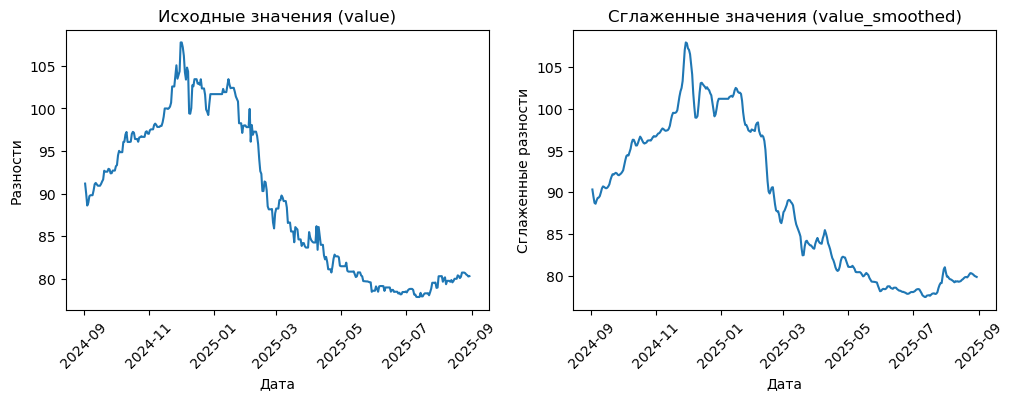

In [36]:
course['value_smoothed'] = course['value_diff_smoothed'].cumsum() + course['value'].iloc[0]

# Визуализация
plt.figure(figsize=(12, 8))
plt.clf()  # Очистка фигуры перед построением

# График значений
plt.subplot(2, 2, 1)
sns.lineplot(x=course['date'], y=course['value'])
plt.title('Исходные значения (value)')
plt.xlabel('Дата')
plt.ylabel('Разности')
plt.xticks(rotation=45)

# График отфильтрованных разностей
plt.subplot(2, 2, 2)
sns.lineplot(x=course['date'], y=course['value_smoothed'])
plt.title('Сглаженные значения (value_smoothed)')
plt.xlabel('Дата')
plt.ylabel('Сглаженные разности')
plt.xticks(rotation=45)

### Проверка на стационарность

Вновь попробуем проверить ряды на стационарность с помощью ADF и KPSS. Проверять будем оба ряда - отфильтрованный и сглаженный.

In [38]:
result = adfuller(course['value_filtered'])
print('Filtered ADF stat:', result[0], 'p-value:', result[1])  # p < 0.05: стационарен
if result[1] < 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = kpss(course['value_filtered'])
print('Filtered KPSS stat:', result[0], 'p-value:', result[1])  # p > 0.05: стационарен
if result[1] > 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = adfuller(course['value_smoothed'])
print('Smoothed ADF stat:', result[0], 'p-value:', result[1])  # p < 0.05: стационарен
if result[1] < 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = kpss(course['value_smoothed'])
print('Smoothed KPSS stat:', result[0], 'p-value:', result[1])  # p > 0.05: стационарен
if result[1] > 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

Filtered ADF stat: -0.8835655518301141 p-value: 0.7933363297172662
Временной ряд нестационарен
Filtered KPSS stat: 2.4084028827674646 p-value: 0.01
Временной ряд нестационарен
Smoothed ADF stat: -0.503892789759306 p-value: 0.8912546033987434
Временной ряд нестационарен
Smoothed KPSS stat: 2.4080051837157503 p-value: 0.01
Временной ряд нестационарен


C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16388\435155246.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(course['value_filtered'])
C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16388\435155246.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(course['value_smoothed'])


Оба ряда сохранили свою нестационарность но есть небольшие изменения:

* Чебышев (value_filtered): Немного лучше приближает ряд к стационарности (ADF: -0.884 vs. -0.670), так как сильнее подавляет шум, но не делает ряд стационарным.
  
* Скользящее среднее (value_smoothed): Ухудшает показатели ADF (-0.504 vs. -0.670), сохраняя больше нестационарных компонентов.

* Общий вывод: оба метода не делают ряд стационарным, но Чебышев ближе к стационарности за счёт подавления высокочастотного шума.

In [40]:
result = adfuller(course['value_diff_filtered'])
print('Filtered ADF stat:', result[0], 'p-value:', result[1])  # p < 0.05: стационарен
if result[1] < 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = kpss(course['value_diff_filtered'])
print('Filtered KPSS stat:', result[0], 'p-value:', result[1])  # p > 0.05: стационарен
if result[1] > 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = adfuller(course['value_diff_smoothed'])
print('Smoothed ADF stat:', result[0], 'p-value:', result[1])  # p < 0.05: стационарен
if result[1] < 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

result = kpss(course['value_diff_smoothed'])
print('Smoothed KPSS stat:', result[0], 'p-value:', result[1])  # p > 0.05: стационарен
if result[1] > 0.05:
    print('Временной ряд стационарен')
else: print('Временной ряд нестационарен')

Filtered ADF stat: -4.2984689733825485 p-value: 0.00044693198389031587
Временной ряд стационарен
Filtered KPSS stat: 0.2743536761665736 p-value: 0.1
Временной ряд стационарен
Smoothed ADF stat: -4.72317061931074 p-value: 7.61111816622644e-05
Временной ряд стационарен
Smoothed KPSS stat: 0.24192778272359763 p-value: 0.1
Временной ряд стационарен


C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16388\3283194573.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(course['value_diff_filtered'])
C:\Users\Thunderobot\AppData\Local\Temp\ipykernel_16388\3283194573.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(course['value_diff_smoothed'])


* Чебышев (value_diff_filtered): Вероятно, слегка усиливает стационарность (меньше высокочастотного шума), но без точных значений сложно сравнить.
* Скользящее среднее (value_diff_smoothed): Поддерживает стационарность, но мягче сохраняет структуру данных.
* Общий вывод: нет значительных различий в стационарности между методами.

### Проверка рядов на наличие трендов

Проверим каждый из рядов на наличие трендов с помощью метода проверки средних уровней.

In [42]:
series_list = ['value', 'value_smoothed', 'value_filtered','value_diff', 'value_diff_smoothed', 'value_diff_filtered']

# Разность средних уровней (t-тест)
midpoint = len(course) // 2
for series in series_list:
    first_half = course[series].iloc[:midpoint]
    second_half = course[series].iloc[midpoint:]
    t_stat, p_val = ttest_ind(first_half, second_half, equal_var=False)
    print(f"\nt-тест для {series}:")
    print(f"t-статистика: {t_stat:.4f}, p-value: {p_val:.4f}")
    if p_val < 0.05:
        print("Разность средних значима (возможен тренд)")
    else:
        print("Разность средних не значима (тренд маловероятен)")


t-тест для value:
t-статистика: 38.2264, p-value: 0.0000
Разность средних значима (возможен тренд)

t-тест для value_smoothed:
t-статистика: 38.0838, p-value: 0.0000
Разность средних значима (возможен тренд)

t-тест для value_filtered:
t-статистика: 38.1253, p-value: 0.0000
Разность средних значима (возможен тренд)

t-тест для value_diff:
t-статистика: 0.3664, p-value: 0.7144
Разность средних не значима (тренд маловероятен)

t-тест для value_diff_smoothed:
t-статистика: 0.4692, p-value: 0.6393
Разность средних не значима (тренд маловероятен)

t-тест для value_diff_filtered:
t-статистика: 0.5348, p-value: 0.5932
Разность средних не значима (тренд маловероятен)


* Нестационарные ряды (value, value_smoothed, value_filtered):

    * Все имеют значимый тренд (p-value = 0.0000), что согласуется с ADF/KPSS (нестационарность).
      
    * Скользящее среднее и Чебышев немного смягчают тренд (t-статистики ниже: 38.0838 и 38.1253 vs. 38.2264), но он остаётся сильным.

* Стационарные разности (value_diff_smoothed, value_diff_filtered):

    * Тренд отсутствует (p-value > 0.05), что подтверждает стационарность по ADF/KPSS.

    * Скользящее среднее (value_diff_smoothed) показывает чуть меньшую t-статистику (0.4692 vs. 0.5348), что может указывать на лучшее подавление остаточных трендов.